### Practice with European Footall Data Analysis

This data manipulation does not guarantee accurate analysis nor any valuable conclusion, but serves to practice on-hand data analysis with a large, structured dataset. 

The very first destination is to find the most surprising and disappointing teams in the big European leagues in the last decade. 

The dataset is downloaded from kaggle, and owned by Hugo Mathien. It's also maintained at [GitHub](https://github.com/hugomathien/football-data-collection).

## Toolkits

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import sqlite3
import re
import gc

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

## Load data

In [2]:
with sqlite3.connect('database.sqlite') as con:
    matchs = pd.read_sql_query('select * from Match', con)
    countries = pd.read_sql_query('select * from Country', con)
    teams = pd.read_sql_query('select * from Team', con)

## Clean up

In [3]:
big5 = 'England', 'France', 'Germany', 'Italy', 'Spain'
bigLeagues = countries[countries.name.isin(big5)]
bigLeagues

,id,name
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
9,21518,Spain


In [4]:
# data washing -- keep only the interesting columns
desiredColumns = ['id', 'country_id', 'season', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'B365H', 'B365D', 'B365A']
selectedMatches = matchs[matchs.league_id.isin(bigLeagues.id)]
selectedMatches = selectedMatches[desiredColumns]
selectedMatches.tail()

,id,country_id,season,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,B365A
24552,24553,21518,2015/2016,9906,10267,2,1,1.57,3.80,6.50
24553,24554,21518,2015/2016,9864,9783,2,0,2.25,3.25,3.40
24554,24555,21518,2015/2016,8315,9869,3,0,1.53,4.00,7.00
24555,24556,21518,2015/2016,7878,8603,1,1,2.30,3.25,3.25
24556,24557,21518,2015/2016,8370,8558,3,0,2.20,3.40,3.20


In [5]:
# detect corrupted data points
selectedMatches[(selectedMatches.B365H.isnull())]

,id,country_id,season,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,B365A
4857,4858,4769,2008/2009,9830,9748,2,1,NaN,NaN,NaN
5381,5382,4769,2009/2010,9748,9855,2,0,NaN,NaN,NaN
5600,5601,4769,2010/2011,8639,8689,6,3,NaN,NaN,NaN
7715,7716,4769,2015/2016,8592,9830,1,1,NaN,NaN,NaN
9034,9035,7809,2012/2013,10269,8721,0,1,NaN,NaN,NaN
10939,10940,10257,2009/2010,9857,8530,1,1,NaN,NaN,NaN
11146,11147,10257,2010/2011,8533,10233,0,0,NaN,NaN,NaN
11278,11279,10257,2010/2011,10233,9858,3,0,NaN,NaN,NaN
11281,11282,10257,2010/2011,8533,9857,2,0,NaN,NaN,NaN
11539,11540,10257,2011/2012,8686,8636,4,0,NaN,NaN,NaN


In [6]:
# and drop 'em
selectedMatches = selectedMatches[np.isfinite(selectedMatches['B365H'])]

## Performance algorithms

__The Idea__: Set up an x-axis of Expectation and an y-axis of True Performance.

__Expectation__: How many points the bookmakers believe you can get off a single season. **Expectation = sum(expected points for each game in this season)**


e.g. 
Bayern hosts Dortmund at H 2.00, D 4.00, A 4.00. 

The expected points for Bayern is 3 points \* 50% win + 1 point \* 25% draw + 0 point \* 25% lose = 1.75 points.

The expected points for Dortmund is 3 points \* 25% win + 1 point \* 25% draw + 0 point \* 50% lose = 1 points.

I believe it represents well the expected power of a team, since it takes injuries, transfers, win/lose streaks into account (when odds are set).

**True Performance := (Total points in reality) - (Expectation)**

In [7]:
def oddsToProbs(row):
    odds = [row['B365H'], row['B365D'], row['B365A']]
    probs = [1. / o for o in odds]
    norm = sum(probs)
    probs = [p / norm for p in probs]
    return probs

def homePoints(row):
    pts = 1
    if row['home_team_goal'] > row['away_team_goal']:
        pts = 3
    elif row['home_team_goal'] < row['away_team_goal']:
        pts = 0
    return pts

def awayPoints(row):
    pts = 1
    if row['home_team_goal'] > row['away_team_goal']:
        pts = 0
    elif row['home_team_goal'] < row['away_team_goal']:
        pts = 3
    return pts
        
def homeTeamExp(row):
    probs = oddsToProbs(row)
    return (3 * probs[0] + probs[1])

def awayTeamExp(row):
    probs = oddsToProbs(row)
    return (3 * probs[2] + probs[1])

def homeTeamPerformance(row):
    return (homePoints(row) - homeTeamExp(row))

def awayTeamPerformance(row):
    return (awayPoints(row) - awayTeamExp(row))

In [8]:
selectedMatches['home_exp'] = selectedMatches.apply(homeTeamExp, axis=1)
selectedMatches['away_exp'] = selectedMatches.apply(awayTeamExp, axis=1)

selectedMatches['home_pfm'] = selectedMatches.apply(homeTeamPerformance, axis=1)
selectedMatches['away_pfm'] = selectedMatches.apply(awayTeamPerformance, axis=1)

In [9]:
selectedMatches.head()

,id,country_id,season,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,B365A,home_exp,away_exp,home_pfm,away_pfm
1728,1729,1729,2008/2009,10260,10261,1,1,1.29,5.5,11.00,2.392737,0.433759,-1.392737,0.566241
1729,1730,1729,2008/2009,9825,8659,1,0,1.20,6.5,15.00,2.518248,0.335766,0.481752,-0.335766
1730,1731,1729,2008/2009,8472,8650,0,1,5.50,3.6,1.67,0.777810,1.959739,-0.777810,1.040261
1731,1732,1729,2008/2009,8654,8528,2,1,1.91,3.4,4.20,1.766287,0.955133,1.233713,-0.955133
1732,1733,1729,2008/2009,10252,8456,4,2,1.91,3.4,4.33,1.778328,0.941193,1.221672,-0.941193


## Manipulation

In [15]:
exp = []
pfm = []
clr = []

# prepare for outliers
otSeason = []
otExp = []
otPfm = []
otName = []

# set up color - league mapping
colors = ['red', 'green', 'orange', 'purple', 'blue']
colors_mapping = dict(zip(bigLeagues.id, colors))



# register data entries
for season, seasonMatches in selectedMatches.groupby('season'):
    for teamID, teamName in zip(teams.team_api_id, teams.team_long_name):
        teamHM = seasonMatches[seasonMatches.home_team_api_id == teamID]
        teamAM = seasonMatches[seasonMatches.away_team_api_id == teamID]
        teamExp = teamHM['home_exp'].sum() + teamAM['away_exp'].sum()
        teamPfm = teamHM['home_pfm'].sum() + teamAM['away_pfm'].sum()
        if teamExp > 0:
            # rescale corrupted games, and Bundesliga (only 34 games per season)
            teamExp = teamExp / (teamHM['home_exp'].count() + teamAM['home_exp'].count()) * 38
            teamPfm = teamPfm / (teamHM['home_exp'].count() + teamAM['home_exp'].count()) * 38
            teamClr = colors_mapping[teamHM.country_id.values[0]]
            exp.append(teamExp)
            pfm.append(teamPfm)
            clr.append(teamClr)
            
            # set boolean queries
            #outlier = (teamPfm > 19.4) | (teamPfm < -16.4)
            #outlier = (teamPfm > 17.1) | ((teamExp > 78.8) & (teamPfm > 10))
            outlier = (teamPfm < -15.7) | ((teamExp > 60) & (teamPfm < -10))
            
            # keep outliers
            if outlier:
                otSeason.append(season)
                otExp.append(teamExp)
                otPfm.append(teamPfm)
                otName.append(teamName)
                
# manually simplify club names ...
nameDict = {'Hannover 96':'Hannover',
            'Montpellier Hérault SC':'Montpellier',
            'Real Betis Balompié':'Real Betis',
            'Borussia Dortmund':'Dortmund',
            'AJ Auxerre':'Auxerre',
            'Real Madrid CF':'Real Madrid',
            'FC Barcelona':'Barcelona',
            'Manchester City':'Man City',
            'Atlético Madrid':'Atlético',
            'Manchester United':'Man Utd',
            'FC Bayern Munich':'Bayern',
            'Hertha BSC Berlin':'Hertha',
            'Olympique de Marseille':'OM',
            'Queens Park Rangers':'QPR',
            'ES Troyes AC':'Troyes',
            'SV Werder Bremen':'Bremen'
            }
otName = [nameDict[n] if n in nameDict else n for n in otName]


# ... and season representations
import re
otSeason = [re.sub('(20)', '', s) for s in otSeason]

## D3 data output

In [10]:
exp = []
pfm = []
lg = []
sea = []
nm = []
goal = []

# set up color - league mapping
lgfull = ['Premier League', 'Ligue 1', 'Bundesliga', 'Serie A', 'La Liga']
lg_mapping = dict(zip(bigLeagues.id, lgfull))



# register data entries
for season, seasonMatches in selectedMatches.groupby('season'):
    for teamID, teamName in zip(teams.team_api_id, teams.team_long_name):
        teamHM = seasonMatches[seasonMatches.home_team_api_id == teamID]
        teamAM = seasonMatches[seasonMatches.away_team_api_id == teamID]
        teamExp = teamHM['home_exp'].sum() + teamAM['away_exp'].sum()
        teamPfm = teamHM['home_pfm'].sum() + teamAM['away_pfm'].sum()
        if teamExp > 0:
            # rescale corrupted games, and Bundesliga (only 34 games per season)
            teamExp = teamExp / (teamHM['home_exp'].count() + teamAM['home_exp'].count()) * 38
            teamPfm = teamPfm / (teamHM['home_exp'].count() + teamAM['home_exp'].count()) * 38
            teamLg = lg_mapping[teamHM.country_id.values[0]]
            exp.append(teamExp)
            pfm.append(teamPfm)
            lg.append(teamLg)
            sea.append(re.sub('(20)', '', season))
            nm.append(teamName)

In [11]:
d3_df = pd.DataFrame({
        'exp': exp,
        'pfm': pfm,
        'lg': lg,
        'sea': sea,
        'nm': nm,
    })

d3_df['real'] = d3_df.exp + d3_df.pfm

In [12]:
d3_df.head()

,exp,lg,nm,pfm,sea,real
0,81.478943,Premier League,Manchester United,8.521057,08/09,90.0
1,44.970108,Premier League,Newcastle United,-10.970108,08/09,34.0
2,71.936817,Premier League,Arsenal,0.063183,08/09,72.0
3,37.112622,Premier League,West Bromwich Albion,-5.112622,08/09,32.0
4,43.400273,Premier League,Sunderland,-7.400273,08/09,36.0


In [118]:
d3_df.to_csv('eusoccer.csv', index=False)

## Viz

### All teams

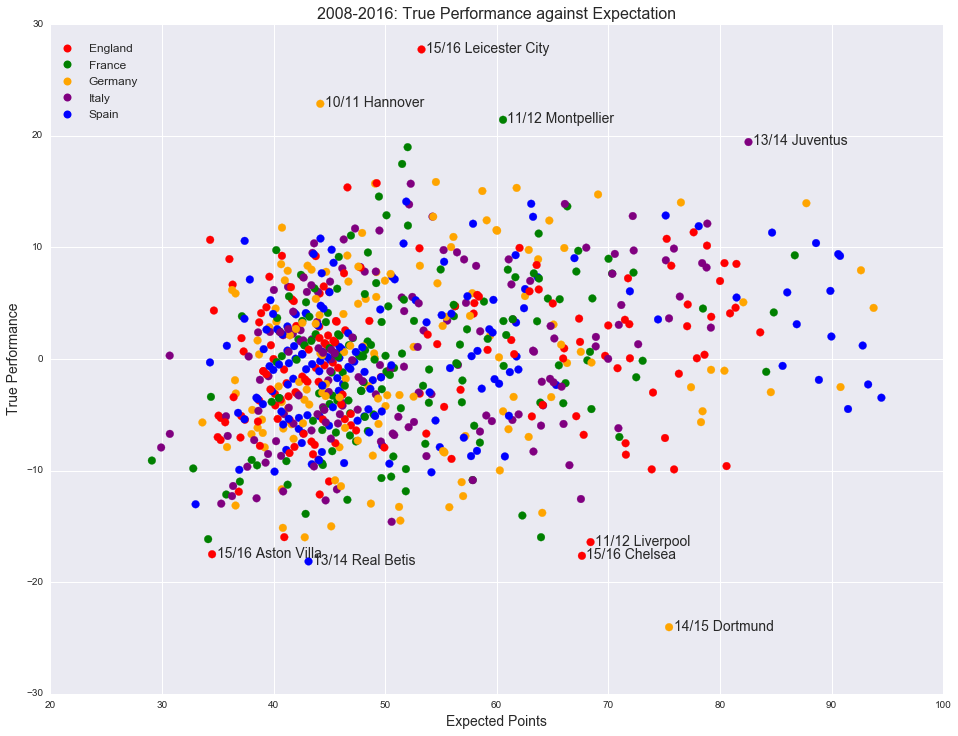

In [12]:
# plot
plt.figure(figsize=(16,12))
plt.scatter(exp, pfm, color=clr, s=[60]*len(exp))
plt.title('2008-2016: True Performance against Expectation', fontsize=16)

# legend
circles = []
labels = []
for leagueID, name in zip(bigLeagues.id, bigLeagues.name):
    labels.append(name)
    circles.append(Line2D([0], [0], linestyle="none", marker="o", markersize=8, markerfacecolor=colors_mapping[leagueID]))
plt.legend(circles, labels, numpoints=1, loc=(0., 0.85), prop={'size': 12})

plt.ylim((-30,30))
plt.xlim((20,100))

# annotation
plt.xlabel('Expected Points', fontsize=14)
plt.ylabel('True Performance', fontsize=14)
ax = plt.gca()

# offset
xoffset = 0.4
yoffset = -0.3

#annotate outliers
for ind, Pfm in enumerate(otPfm):
    ax.annotate(otSeason[ind]+' '+otName[ind], xy=(otExp[ind]+xoffset, Pfm+yoffset), fontsize=14)

### Outperformers

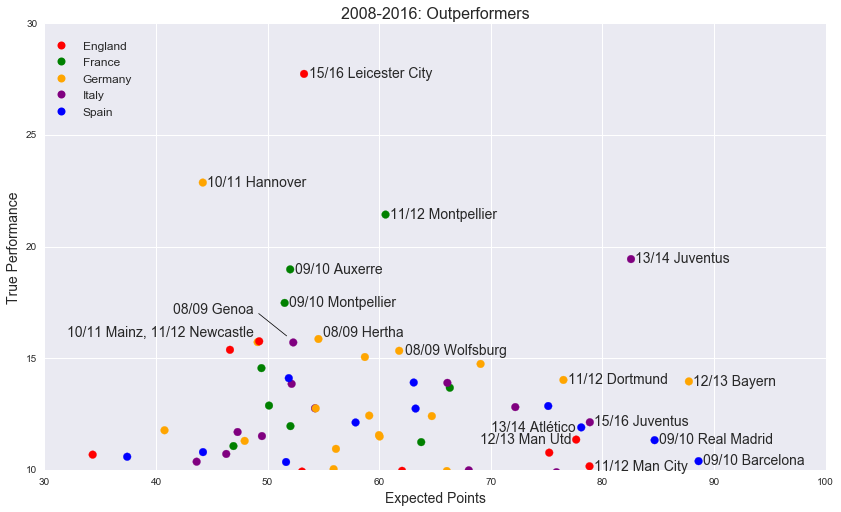

In [14]:
# plot
plt.figure(figsize=(14, 8))
plt.scatter(exp, pfm, color=clr, s=[60]*len(exp))
plt.title('2008-2016: Outperformers', fontsize=16)

# legend
circles = []
labels = []
for leagueID, name in zip(bigLeagues.id, bigLeagues.name):
    labels.append(name)
    circles.append(Line2D([0], [0], linestyle="none", marker="o", markersize=8, markerfacecolor=colors_mapping[leagueID]))
plt.legend(circles, labels, numpoints=1, loc=(0., 0.78), prop={'size': 12})

plt.ylim((10,30))
plt.xlim((30,100))

# annotation
plt.xlabel('Expected Points', fontsize=14)
plt.ylabel('True Performance', fontsize=14)
ax = plt.gca()

# offset
xoffset = 0.4
yoffset = -0.15

#annotate outliers
for ind, Pfm in enumerate(otPfm):
    ax.annotate(otSeason[ind]+' '+otName[ind], xy=(otExp[ind]+xoffset, Pfm+yoffset), fontsize=14)


ax.annotate('12/13 Man Utd', xy=(69, 11.2), fontsize=14)
ax.annotate('13/14 Atlético', xy=(70, 11.75), fontsize=14)
ax.annotate('11/12 Dortmund', xy=(76.9, 13.9), fontsize=14)

ax.annotate('08/09 Wolfsburg', xy=(62.3, 15.2), fontsize=14)
ax.annotate('08/09 Genoa', xy=(41.5, 17), fontsize=14)
plt.plot([49.2, 51.7], [17, 16], 'k-', lw=0.75)
ax.annotate('08/09 Hertha', xy=(55, 16), fontsize=14)
ax.annotate('10/11 Mainz, 11/12 Newcastle', xy=(32, 16), fontsize=14) 

### Les Misérables

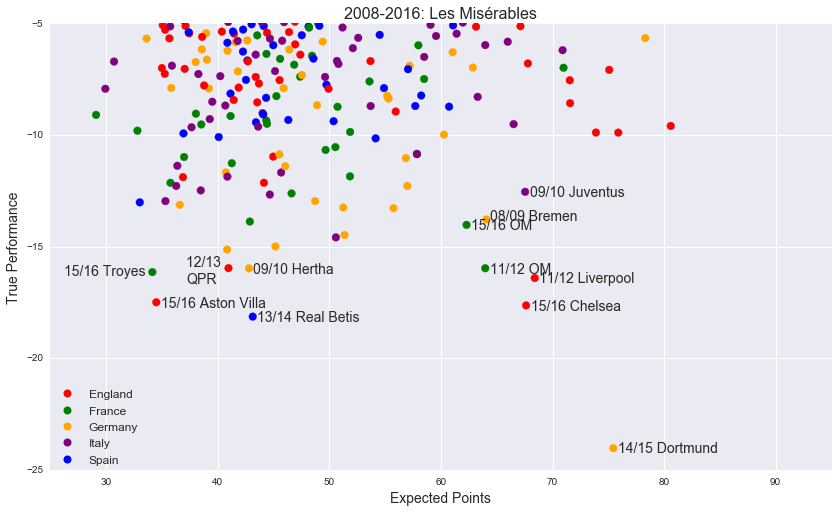

In [17]:
# plot
plt.figure(figsize=(14, 8))
plt.scatter(exp, pfm, color=clr, s=[60]*len(exp))
plt.title('2008-2016: Les Misérables', fontsize=16)

# legend
circles = []
labels = []
for leagueID, name in zip(bigLeagues.id, bigLeagues.name):
    labels.append(name)
    circles.append(Line2D([0], [0], linestyle="none", marker="o", markersize=8, markerfacecolor=colors_mapping[leagueID]))
plt.legend(circles, labels, numpoints=1, loc=(0., 0.), prop={'size': 12})

plt.ylim((-25,-5))
plt.xlim((25,95))

# annotation
plt.xlabel('Expected Points', fontsize=14)
plt.ylabel('True Performance', fontsize=14)
ax = plt.gca()

# offset
xoffset = 0.4
yoffset = -0.2

#annotate outliers
for ind, Pfm in enumerate(otPfm):
    # manually relocate some annotations
    if ((otName[ind] != 'Troyes') & (otName[ind] != 'QPR') & (otName[ind] != 'Bremen')):
        ax.annotate(otSeason[ind]+' '+otName[ind], xy=(otExp[ind]+xoffset, Pfm+yoffset), fontsize=14)

ax.annotate('15/16 Troyes', xy=(26.2, -16.3), fontsize=14)
ax.annotate('12/13     \nQPR', xy=(37.2, -16.6), fontsize=14)
ax.annotate('08/09 Bremen', xy=(64.4, -13.8), fontsize=14)

## Into Leagues (starting from d3_df)

### Expectation Distribution

In [17]:
sns.set()

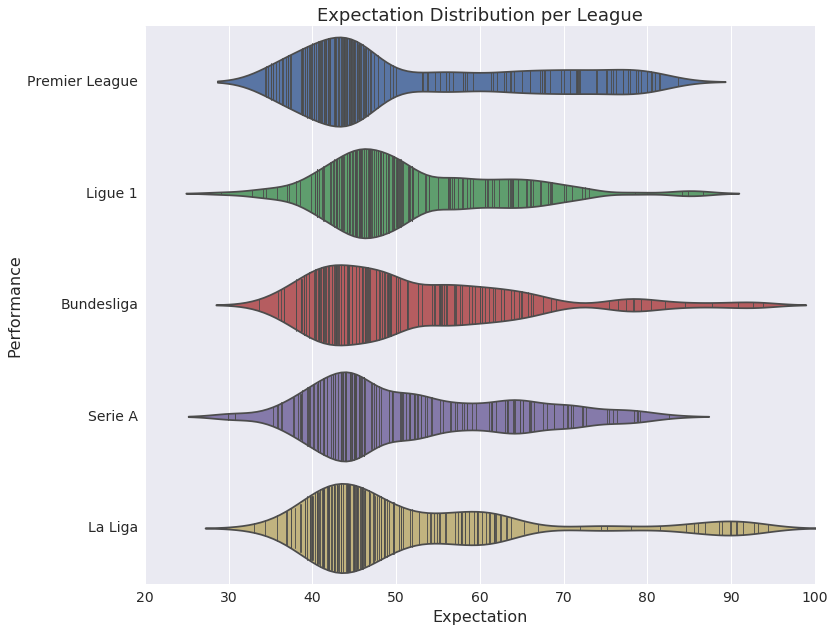

In [18]:
plt.figure(figsize=(12, 10))
sns.violinplot(x='exp', y='lg', data=d3_df, bw=.2, inner='stick', scale='count')
plt.xlim(20, 100)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Expectation', fontsize=16)
plt.ylabel('Performance', fontsize=16)
plt.title('Expectation Distribution per League', fontsize=18)

### Premier League teams

In [31]:
epl_df = d3_df[d3_df['lg'] == 'Premier League']

In [32]:
# sort by avg exp
def avg_exp(row):
    temp_df = epl_df[epl_df['nm'] == row['nm']]
    return temp_df['exp'].sum() / temp_df.shape[0]

In [33]:
epl_df['avg_exp'] = epl_df.apply(avg_exp, axis=1)
epl_df = epl_df.sort_values('avg_exp', ascending=False)

/Users/macnirgu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


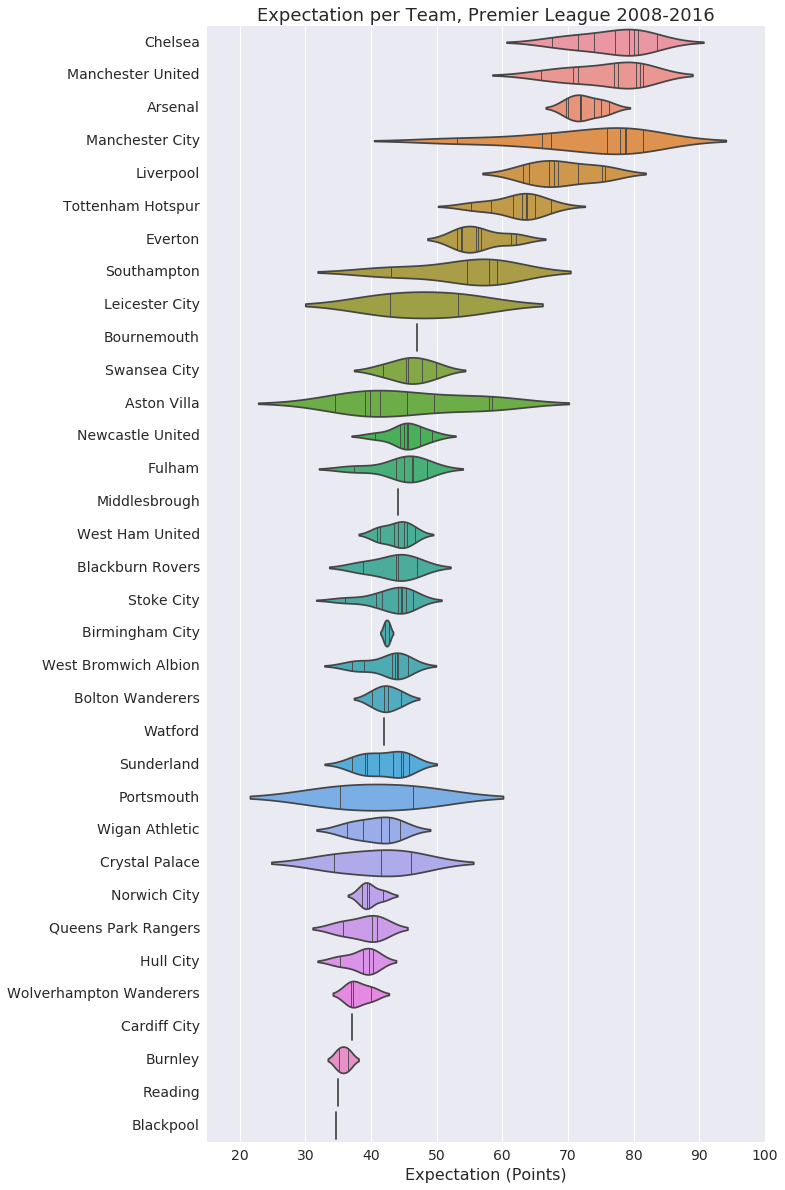

In [34]:
plt.figure(figsize=(10, 20))
sns.violinplot(x='exp', y='nm', data=epl_df, inner='stick', scale='width')
plt.xlim(15, 100)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Expectation (Points)', fontsize=16)
plt.ylabel('')
plt.title('Expectation per Team, Premier League 2008-2016', fontsize=18)

In [23]:
# add missing 16/17 data
new_df = pd.read_csv('1617.csv')
epl_df = epl_df.append(new_df, ignore_index=True)

In [24]:
# sort by avg real points
def avg_real(row):
    temp_df = epl_df[epl_df['nm'] == row['nm']]
    return temp_df['real'].sum() / temp_df.shape[0]

In [25]:
epl_df['avg_real'] = epl_df.apply(avg_real, axis=1)
epl_df = epl_df.sort_values('avg_real', ascending=False)

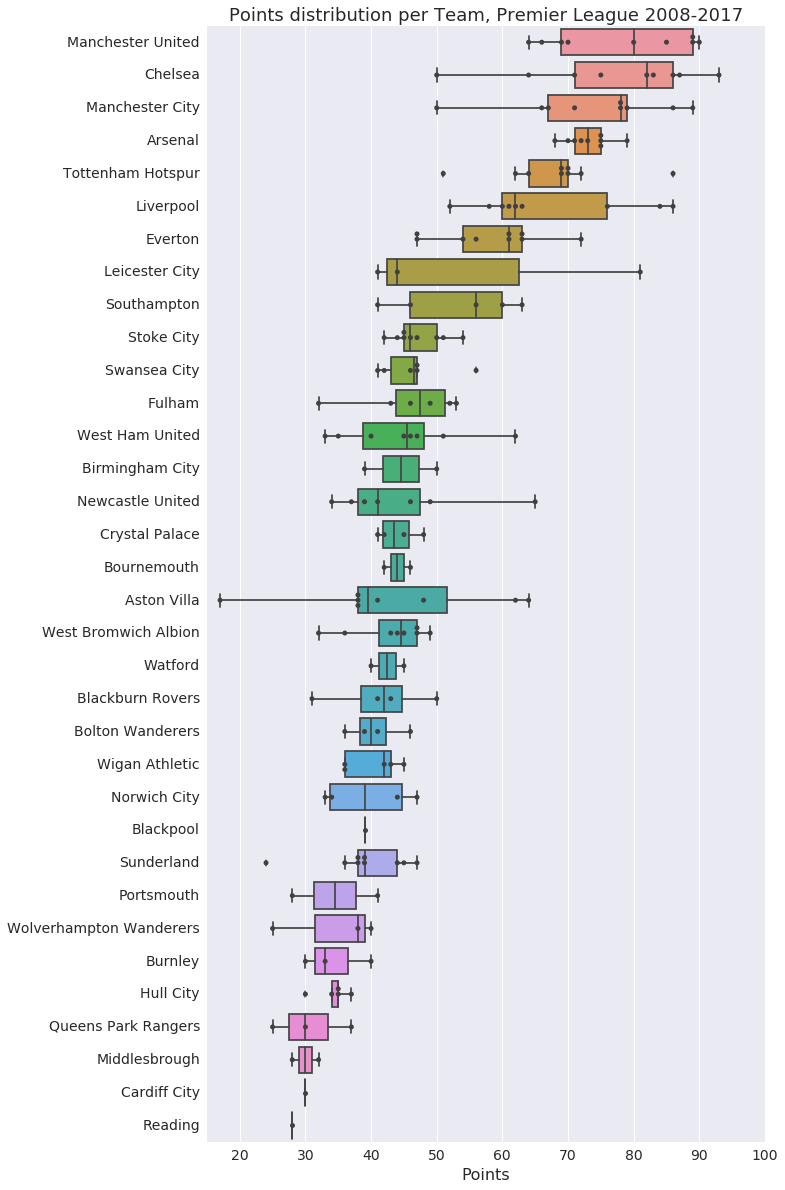

In [26]:
plt.figure(figsize=(10, 20))
sns.boxplot(x='real', y='nm', data=epl_df, whis=2)
sns.swarmplot(x='real', y='nm', data=epl_df, color='.25')
plt.xlim(15, 100)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Points', fontsize=16)
plt.ylabel('')
plt.title('Points distribution per Team, Premier League 2008-2017', fontsize=18)

## Chinese Viz

In [27]:
# font path
import matplotlib.font_manager as mfm
font_path = '/Library/Fonts/华文细黑.ttf'
font = mfm.FontProperties(fname=font_path)
cnLeagueNames = ['英超', '法甲', '德甲', '意甲', '西甲']

## Reference

[This](https://www.kaggle.com/yonilev/the-most-predictable-league) kaggle kernel was __heavily__ referred to.